<a href="https://colab.research.google.com/github/mabuice/AMATH_Visual_Coding/blob/main/Homework_Decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
<h3> This notebook will explore decoding using the Allen Brain Observatory data </h3>
    
In this notebook, we'll look at decoding using different models, different definitions of the design matrix, and different neural populations.


In [1]:
# @title Run to initialize Allen Brain Observatory on Colab {display-mode: "form" }
# run only once per runtime/session, and only if running in colab
# the runtime will need to restart after
%%capture
!apt install s3fs
!pip install allensdk
!mkdir -p /data/allen-brain-observatory/
!s3fs allen-brain-observatory /data/allen-brain-observatory/ -o public_bucket=1

### Standard imports

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split


### Allen Brain Observatory set up

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The command below returns a list of dictionaries containing information about the experiment sessions.  As we saw in the main notebook, you can use optional arguments to specify subsets of experiment sessions.  (Hint:  use the help function to see other ways of choosing sessions.)
</div>

In [4]:
exps = boc.get_ophys_experiments()

In [5]:
pd.DataFrame(exps)

,id,imaging_depth,targeted_structure,cre_line,reporter_line,acquisition_age_days,experiment_container_id,session_type,donor_name,specimen_name,fail_eye_tracking
0,566752133,175,VISl,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),116,564425775,three_session_C2,283147,Emx1-IRES-Cre;Camk2a-tTA;Ai93-283147,True
1,653123586,275,VISl,Rorb-IRES2-Cre,Ai93(TITL-GCaMP6f),111,653123584,three_session_C2,352471,Rorb-IRES2-Cre;Camk2a-tTA;Ai93-352471,True
2,577225417,275,VISl,Vip-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),105,575772104,three_session_C2,296710,Vip-IRES-Cre;Ai148-296710,False
3,556353209,375,VISam,Rbp4-Cre_KL100,Ai93(TITL-GCaMP6f),101,555327033,three_session_A,271750,Rbp4-Cre;Camk2a-tTA;Ai93-271750,True
4,510390912,275,VISal,Rorb-IRES2-Cre,Ai93(TITL-GCaMP6f),80,511500480,three_session_A,232623,Rorb-IRES2-Cre;Camk2a-tTA;Ai93-232623,False
...,...,...,...,...,...,...,...,...,...,...,...
1363,577820172,275,VISam,Rorb-IRES2-Cre,Ai93(TITL-GCaMP6f),110,576411244,three_session_B,295995,Rorb-IRES2-Cre;Camk2a-tTA;Ai93-295995,False
1364,648389302,275,VISp,Slc17a7-IRES2-Cre,Ai93(TITL-GCaMP6f),108,647155120,three_session_B,347751,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751,False
1365,510517609,375,VISpm,Rbp4-Cre_KL100,Ai93(TITL-GCaMP6f),75,511511006,three_session_B,233442,Rbp4-Cre;Camk2a-tTA;Ai93-233442,False
1366,547560448,350,VISal,Nr5a1-Cre,Ai93(TITL-GCaMP6f),107,546328009,three_session_C2,261969,Nr5a1-Cre;Camk2a-tTA;Ai93-261969,False


The following function will grab the data_set object for a given session_id.  The last two lines will extract the dF/F traces and the stimulus table for a given stimulus type.  

Some other stimulus types are `natural_scenes` and `static_gratings`.

In [14]:
session_id = 627823695
data_set = boc.get_ophys_experiment_data(session_id)

timestamps, dff = data_set.get_dff_traces()
stim_table = data_set.get_stimulus_table('drifting_gratings')
timestamps, dff = data_set.get_dff_traces()
stim_table = data_set.get_stimulus_table('drifting_gratings')

**Exercise 1:** Use a different decoder and repeat the same analysis.  Good decoders to try are Logistic Regression, Support Vector Machine, K-Means.

Logistic Regression:
https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html

Support Vector Machine:
https://scikit-learn.org/1.6/modules/generated/sklearn.svm.SVC.html

(Note:  look through the documentation to see what parameters govern these decoders.  How should you set them?  What effect do they have on the performance of your classifier?)


In [19]:
print(stim_table.columns)

Index(['temporal_frequency', 'orientation', 'blank_sweep', 'start', 'end'], dtype='object')


In [32]:
# ================================
# Exercise 1: Using Different Decoders (Self-Contained)
# ================================

# --- Step 1: Retrieve the Data for a Drifting Gratings Session ---

# Find sessions that include the drifting gratings stimulus.
exps = boc.get_ophys_experiments(stimuli=['drifting_gratings'])
print("Found", len(exps), "session(s) with drifting gratings stimulus.")

# Use the first session in the list.
session_id = exps[0]['id']
print("Using session_id:", session_id)

# Get the experiment data for this session.
data_set = boc.get_ophys_experiment_data(session_id)

# Retrieve the dF/F traces for all neurons.
# dff has shape: [num_neurons, num_frames]
timestamps, dff = data_set.get_dff_traces()

# Retrieve the stimulus table for the drifting gratings stimulus.
# (This should now work since we selected a session known to include drifting gratings.)
stim_table = data_set.get_stimulus_table('drifting_gratings')

# --- Step 2: Build the Design Matrix and Label Vector ---
# Each row in the design matrix ("activity") corresponds to a trial.
# Each column corresponds to a neuron.
num_trials = stim_table.shape[0]
num_neurons = dff.shape[0]

activity = np.zeros((num_trials, num_neurons))
stim_tf = []  # We will use the temporal frequency as the stimulus label.

# Loop over each trial to compute the mean response per neuron.
for i, row in stim_table.iterrows():
    # Compute the mean DF/F response for each neuron for frames from 'start' to 'end'.
    activity[i, :] = dff[:, int(row.start):int(row.end)].mean(axis=1)

    # Use the temporal frequency as the label if valid; otherwise, use 'blank'
    if np.isfinite(row.temporal_frequency):
        stim_tf.append(str(row.temporal_frequency))
    else:
        stim_tf.append('blank')

stim_tf = np.array(stim_tf)

print("Activity shape (trials x neurons):", activity.shape)
print("Stimulus label vector shape:", stim_tf.shape)


# --- Step 3: Split the Data into Training and Testing Sets ---
# Use 75% of trials for training and 25% for testing.
test_index = int(0.75 * num_trials)

activity_train = activity[:test_index, :]
activity_test  = activity[test_index:, :]

stim_tf_train = stim_tf[:test_index]
stim_tf_test  = stim_tf[test_index:]


# --- Step 4: Apply Different Decoders ---

# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(activity_train, stim_tf_train)
pred_lr = clf_lr.predict(activity_test)
acc_lr = np.mean(pred_lr == stim_tf_test)
print("Logistic Regression Test Accuracy: {:.2f}%".format(acc_lr * 100))


# 2. Support Vector Machine (SVM)
from sklearn.svm import SVC

clf_svc = SVC()  # You can adjust parameters (e.g., kernel, C) if desired.
clf_svc.fit(activity_train, stim_tf_train)
pred_svc = clf_svc.predict(activity_test)
acc_svc = np.mean(pred_svc == stim_tf_test)
print("SVM Test Accuracy: {:.2f}%".format(acc_svc * 100))


# 3. K-Means Clustering (Unsupervised)
# K-Means will cluster the training data, and we assign a label to each cluster based on the mode.
from sklearn.cluster import KMeans
import scipy.stats as stats

unique_labels = np.unique(stim_tf_train)
n_clusters = len(unique_labels)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_clusters = kmeans.fit_predict(activity_train)

# Map each cluster to the most common stimulus label in the training data.
cluster_to_label = {}
for cl in np.unique(train_clusters):
    mask = (train_clusters == cl)
    common_label = stats.mode(stim_tf_train[mask])[0][0]
    cluster_to_label[cl] = common_label
    print(f"Cluster {cl}: assigned label {common_label}")

# Predict clusters for the test set and map clusters to labels.
test_clusters = kmeans.predict(activity_test)
pred_km = np.array([cluster_to_label[cl] for cl in test_clusters])
acc_km = np.mean(pred_km == stim_tf_test)
print("K-Means (Unsupervised) Test 'Accuracy': {:.2f}%".format(acc_km * 100))


Found 456 session(s) with drifting gratings stimulus.
Using session_id: 556353209
Activity shape (trials x neurons): (628, 21)
Stimulus label vector shape: (628,)
Logistic Regression Test Accuracy: 19.11%
SVM Test Accuracy: 16.56%


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7ca8c8af0540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72

Cluster 0: assigned label 8.0
Cluster 1: assigned label 2.0
Cluster 2: assigned label 8.0
Cluster 3: assigned label 15.0
Cluster 4: assigned label 1.0
Cluster 5: assigned label 15.0
K-Means (Unsupervised) Test 'Accuracy': 16.56%


<ipython-input-32-8336519e9c9e>:100: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  common_label = stats.mode(stim_tf_train[mask])[0][0]
<ipython-input-32-8336519e9c9e>:100: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  common_label = stats.mode(stim_tf_train[mask])[0][0]


**Exercise 2:** Use a different stimulus type.  In addition to ‘drifting_gratings’, there are also ‘natural_scenes’ and ‘static_gratings’.  Find a session with these stimuli and try decoding the stimulus condition.

(Hint:  use the function given above to get a list of experiments and convert it to a dataframe).*italicized text*
</div>

In [33]:
exps_ns = boc.get_ophys_experiments(stimuli=['natural_scenes'])
print("Found", len(exps_ns), "session(s) with natural scenes stimulus.")

# Use the first session from the natural scenes experiments.
session_id_ns = exps_ns[0]['id']
print("Using session_id for natural scenes:", session_id_ns)

# Get the experiment data for this session.
data_set_ns = boc.get_ophys_experiment_data(session_id_ns)

# Retrieve the dF/F traces for all neurons.
# dff_ns will have shape: [num_neurons, num_frames]
timestamps_ns, dff_ns = data_set_ns.get_dff_traces()

# Retrieve the stimulus table for the natural scenes stimulus.
stim_table_ns = data_set_ns.get_stimulus_table('natural_scenes')

# Optionally, print the first few rows to inspect the table.
print("Natural Scenes Stimulus Table (first 5 rows):")
print(stim_table_ns.head(5))


# --- Step 2: Build the Design Matrix and Label Vector ---
# For natural scenes, we assume that the stimulus table includes a column named "image_id"
# which identifies the natural scene image presented on each trial.

num_trials_ns = stim_table_ns.shape[0]
num_neurons_ns = dff_ns.shape[0]

activity_ns = np.zeros((num_trials_ns, num_neurons_ns))
stim_ns = []  # This will hold the stimulus condition (image_id) for each trial.

for i, row in stim_table_ns.iterrows():
    # Compute the mean DF/F response for each neuron over the trial.
    activity_ns[i, :] = dff_ns[:, int(row.start):int(row.end)].mean(axis=1)

    # Use the 'image_id' as the label if it exists and is finite; otherwise, label it as 'blank'.
    if 'image_id' in stim_table_ns.columns and np.isfinite(row.image_id):
        stim_ns.append(str(row.image_id))
    else:
        stim_ns.append('blank')

stim_ns = np.array(stim_ns)

print("Activity shape (natural scenes):", activity_ns.shape)
print("Unique natural scenes labels:", np.unique(stim_ns))


# --- Step 3: Split the Data into Training and Testing Sets ---
# Use 75% of the trials for training and 25% for testing.
test_index_ns = int(0.75 * num_trials_ns)

activity_ns_train = activity_ns[:test_index_ns, :]
activity_ns_test  = activity_ns[test_index_ns:, :]

stim_ns_train = stim_ns[:test_index_ns]
stim_ns_test  = stim_ns[test_index_ns:]


# --- Step 4: Decode the Natural Scenes Stimulus Condition ---
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf_ns = LDA()
clf_ns.fit(activity_ns_train, stim_ns_train)

pred_ns = clf_ns.predict(activity_ns_test)
acc_ns = np.mean(pred_ns == stim_ns_test)
print("Natural Scenes Decoding Test Accuracy (LDA): {:.2f}%".format(acc_ns * 100))

Found 456 session(s) with natural scenes stimulus.
Using session_id for natural scenes: 645474010
Natural Scenes Stimulus Table (first 5 rows):
   frame  start    end
0    106  16913  16920
1     21  16921  16928
2     98  16929  16936
3     97  16936  16944
4     91  16944  16951
Activity shape (natural scenes): (5950, 25)
Unique natural scenes labels: ['blank']
Natural Scenes Decoding Test Accuracy (LDA): 100.00%


**Exercise 3:** Compare the decoding performance between sessions from different areas.  Does decoding of drifting gratings work better in VISp compared to other areas?  
</div>

In [34]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- Step 1: Retrieve All Drifting Gratings Sessions ---
exps = boc.get_ophys_experiments(stimuli=['drifting_gratings'])
print("Found", len(exps), "sessions with drifting gratings stimulus.")

# Convert the list of session dictionaries to a DataFrame.
df_exps = pd.DataFrame(exps)

# Get the unique targeted structures (brain areas).
unique_areas = df_exps['targeted_structure'].unique()
print("Unique targeted structures in drifting gratings sessions:", unique_areas)

# Dictionary to store decoding accuracies for each area.
decoding_results = {}

# --- Step 2: Iterate Through Each Brain Area and Decode ---
for area in unique_areas:
    # Filter the sessions for this area.
    sessions_area = df_exps[df_exps['targeted_structure'] == area]
    if sessions_area.empty:
        continue

    # Pick the first session from this area.
    session_id = sessions_area.iloc[0]['id']
    print("\nProcessing area:", area, "using session_id:", session_id)

    try:
        data_set = boc.get_ophys_experiment_data(session_id)
        stim_table = data_set.get_stimulus_table('drifting_gratings')
    except Exception as e:
        print("Error retrieving drifting gratings for session", session_id, ":", e)
        continue

    # Retrieve the dF/F traces: shape = [num_neurons, num_frames]
    timestamps, dff = data_set.get_dff_traces()

    # --- Build the Design Matrix and Stimulus Labels ---
    num_trials = stim_table.shape[0]
    num_neurons = dff.shape[0]
    if num_trials == 0 or num_neurons == 0:
        print("No trials or neurons found for session", session_id)
        continue

    # We will use each trial's orientation as the stimulus label.
    activity = np.zeros((num_trials, num_neurons))
    stim_labels = []  # to hold orientation values (as strings)

    for i, row in stim_table.iterrows():
        # Compute the mean response per neuron for the trial.
        activity[i, :] = dff[:, int(row.start):int(row.end)].mean(axis=1)
        # Use orientation if valid; if not (e.g., blank trials), label as 'blank'
        if np.isfinite(row.orientation):
            stim_labels.append(str(row.orientation))
        else:
            stim_labels.append('blank')

    stim_labels = np.array(stim_labels)

    # --- Exclude Blank Trials ---
    valid_idx = stim_labels != 'blank'
    activity = activity[valid_idx, :]
    stim_labels = stim_labels[valid_idx]

    # Ensure there is more than one condition to decode.
    if len(np.unique(stim_labels)) < 2:
        print("Not enough stimulus conditions for decoding in area", area)
        continue

    # --- Split Data: 75% Training, 25% Testing ---
    num_valid = activity.shape[0]
    test_index = int(0.75 * num_valid)

    activity_train = activity[:test_index, :]
    activity_test  = activity[test_index:, :]
    stim_train = stim_labels[:test_index]
    stim_test  = stim_labels[test_index:]

    # --- Decode Using LDA ---
    clf = LDA()
    clf.fit(activity_train, stim_train)
    pred = clf.predict(activity_test)
    accuracy = np.mean(pred == stim_test)
    decoding_results[area] = accuracy
    print("Decoding accuracy for area", area, ":", accuracy)

# --- Summary of Results ---
print("\nDecoding Performance by Brain Area:")
for area, acc in decoding_results.items():
    print(f"{area}: {acc:.2f}")

# Example: Check if VISp shows higher accuracy than other areas.
if "VISp" in decoding_results:
    print(f"\nVISp decoding accuracy: {decoding_results['VISp']:.2f}")
else:
    print("\nNo VISp session available in the dataset.")


Found 456 sessions with drifting gratings stimulus.
Unique targeted structures in drifting gratings sessions: ['VISam' 'VISal' 'VISp' 'VISl' 'VISpm' 'VISrl']

Processing area: VISam using session_id: 556353209
Decoding accuracy for area VISam : 0.2

Processing area: VISal using session_id: 510390912
Decoding accuracy for area VISal : 0.47333333333333333

Processing area: VISp using session_id: 704298735
Decoding accuracy for area VISp : 0.7

Processing area: VISl using session_id: 653123929
Decoding accuracy for area VISl : 0.7333333333333333

Processing area: VISpm using session_id: 626027944
Decoding accuracy for area VISpm : 0.18666666666666668

Processing area: VISrl using session_id: 581597734
Decoding accuracy for area VISrl : 0.43333333333333335

Decoding Performance by Brain Area:
VISam: 0.20
VISal: 0.47
VISp: 0.70
VISl: 0.73
VISpm: 0.19
VISrl: 0.43

VISp decoding accuracy: 0.70


**Exercise 4:**  Compare the decoding performance between sessions from different areas of similar depth.</div>

In [35]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- Step 1: Retrieve All Drifting Gratings Sessions ---
exps = boc.get_ophys_experiments(stimuli=['drifting_gratings'])
print("Found", len(exps), "sessions with drifting gratings stimulus.")

# Convert sessions to a DataFrame.
df_exps = pd.DataFrame(exps)

# --- Step 2: Filter Sessions by Imaging Depth ---
# Define a depth range for "similar depth." For example, sessions with imaging_depth between 300 and 400 µm.
depth_min = 300
depth_max = 400
df_depth = df_exps[(df_exps['imaging_depth'] >= depth_min) & (df_exps['imaging_depth'] <= depth_max)]
print("Number of sessions with imaging_depth between", depth_min, "and", depth_max, ":", len(df_depth))

# Get the unique targeted structures (brain areas) in this depth range.
unique_areas = df_depth['targeted_structure'].unique()
print("Unique targeted structures in selected depth range:", unique_areas)

# Dictionary to store decoding accuracies for each area.
decoding_results_depth = {}

# --- Step 3: Iterate Through Each Brain Area and Decode ---
for area in unique_areas:
    # Filter sessions for this area.
    sessions_area = df_depth[df_depth['targeted_structure'] == area]
    if sessions_area.empty:
        continue

    # Select the first session from this area.
    session_id = sessions_area.iloc[0]['id']
    depth = sessions_area.iloc[0]['imaging_depth']
    print("\nProcessing area:", area, "with session_id:", session_id, "and imaging_depth:", depth)

    try:
        data_set = boc.get_ophys_experiment_data(session_id)
        stim_table = data_set.get_stimulus_table('drifting_gratings')
    except Exception as e:
        print("Error retrieving drifting gratings data for session", session_id, ":", e)
        continue

    # Retrieve the dF/F traces for all neurons.
    timestamps, dff = data_set.get_dff_traces()
    num_trials = stim_table.shape[0]
    num_neurons = dff.shape[0]

    # --- Build the Design Matrix and Stimulus Labels ---
    # Here we use the trial's grating orientation as the stimulus label.
    activity = np.zeros((num_trials, num_neurons))
    stim_labels = []  # to hold orientation values as strings.

    for i, row in stim_table.iterrows():
        activity[i, :] = dff[:, int(row.start):int(row.end)].mean(axis=1)
        # If orientation is finite, use it; otherwise (e.g., blank trials), label as 'blank'.
        if np.isfinite(row.orientation):
            stim_labels.append(str(row.orientation))
        else:
            stim_labels.append('blank')

    stim_labels = np.array(stim_labels)

    # Exclude blank trials.
    valid_idx = stim_labels != 'blank'
    activity = activity[valid_idx, :]
    stim_labels = stim_labels[valid_idx]

    # Ensure there is more than one condition.
    if len(np.unique(stim_labels)) < 2:
        print("Not enough stimulus conditions for decoding in area", area)
        continue

    # --- Split Data: 75% Training, 25% Testing ---
    num_valid = activity.shape[0]
    test_index = int(0.75 * num_valid)

    activity_train = activity[:test_index, :]
    activity_test  = activity[test_index:, :]
    stim_train = stim_labels[:test_index]
    stim_test  = stim_labels[test_index:]

    # --- Decode Using LDA ---
    clf = LDA()
    clf.fit(activity_train, stim_train)
    pred = clf.predict(activity_test)
    accuracy = np.mean(pred == stim_test)
    decoding_results_depth[area] = accuracy
    print("Decoding accuracy for area", area, ":", accuracy)

# --- Summary of Results ---
print("\nDecoding Performance (for sessions with imaging_depth between", depth_min, "and", depth_max, "):")
for area, acc in decoding_results_depth.items():
    print(f"{area}: {acc:.2f}")

if "VISp" in decoding_results_depth:
    print(f"\nVISp decoding accuracy: {decoding_results_depth['VISp']:.2f}")
else:
    print("\nNo VISp session available in the selected depth range.")


Found 456 sessions with drifting gratings stimulus.
Number of sessions with imaging_depth between 300 and 400 : 156
Unique targeted structures in selected depth range: ['VISam' 'VISl' 'VISp' 'VISal' 'VISrl' 'VISpm']

Processing area: VISam with session_id: 556353209 and imaging_depth: 375
Decoding accuracy for area VISam : 0.2

Processing area: VISl with session_id: 645689073 and imaging_depth: 375
Decoding accuracy for area VISl : 0.6

Processing area: VISp with session_id: 662033243 and imaging_depth: 375
Decoding accuracy for area VISp : 0.42

Processing area: VISal with session_id: 588483711 and imaging_depth: 375
Decoding accuracy for area VISal : 0.6

Processing area: VISrl with session_id: 571006300 and imaging_depth: 350
Decoding accuracy for area VISrl : 0.4266666666666667

Processing area: VISpm with session_id: 601368107 and imaging_depth: 375
Decoding accuracy for area VISpm : 0.29333333333333333

Decoding Performance (for sessions with imaging_depth between 300 and 400 ):


**Exercise 5:** Compare the decoding performance between sessions from different Cre lines of VISp.


In [36]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- Step 1: Retrieve All Drifting Gratings Sessions and Filter for VISp ---
exps = boc.get_ophys_experiments(stimuli=['drifting_gratings'])
df_exps = pd.DataFrame(exps)
print("Total drifting gratings sessions found:", len(df_exps))

# Filter for sessions in VISp
df_visp = df_exps[df_exps['targeted_structure'] == 'VISp']
print("Number of VISp sessions:", len(df_visp))

# --- Step 2: Group the VISp Sessions by Cre Line ---
# The 'cre_line' field contains the Cre line information.
cre_groups = df_visp.groupby('cre_line')
decoding_results_cre = {}

# --- Step 3: Iterate Through Each Cre Line Group and Decode ---
for cre_line, group in cre_groups:
    # Select the first session from this Cre line group.
    session_id = group.iloc[0]['id']
    print("\nProcessing Cre line:", cre_line, "with session_id:", session_id)

    try:
        data_set = boc.get_ophys_experiment_data(session_id)
        stim_table = data_set.get_stimulus_table('drifting_gratings')
    except Exception as e:
        print("Error retrieving data for session", session_id, ":", e)
        continue

    # Retrieve the dF/F traces (shape: [num_neurons, num_frames])
    timestamps, dff = data_set.get_dff_traces()
    num_trials = stim_table.shape[0]
    num_neurons = dff.shape[0]

    # --- Build the Design Matrix and Stimulus Labels ---
    # We use the grating orientation (if valid) as the stimulus label.
    activity = np.zeros((num_trials, num_neurons))
    stim_labels = []  # to hold orientation values (as strings)

    for i, row in stim_table.iterrows():
        # Compute mean DF/F response for each neuron during the trial.
        activity[i, :] = dff[:, int(row.start):int(row.end)].mean(axis=1)
        # Use orientation if available; otherwise, mark as 'blank'
        if np.isfinite(row.orientation):
            stim_labels.append(str(row.orientation))
        else:
            stim_labels.append('blank')

    stim_labels = np.array(stim_labels)

    # Exclude blank trials from decoding.
    valid_idx = stim_labels != 'blank'
    activity = activity[valid_idx, :]
    stim_labels = stim_labels[valid_idx]

    # Ensure there are at least two stimulus conditions to decode.
    if len(np.unique(stim_labels)) < 2:
        print("Not enough stimulus conditions for decoding in Cre line", cre_line)
        continue

    # --- Split Data: 75% Training, 25% Testing ---
    num_valid = activity.shape[0]
    test_index = int(0.75 * num_valid)

    activity_train = activity[:test_index, :]
    activity_test  = activity[test_index:, :]
    stim_train = stim_labels[:test_index]
    stim_test  = stim_labels[test_index:]

    # --- Decode Using LDA ---
    clf = LDA()
    clf.fit(activity_train, stim_train)
    pred = clf.predict(activity_test)
    accuracy = np.mean(pred == stim_test)
    decoding_results_cre[cre_line] = accuracy
    print("Decoding accuracy for Cre line", cre_line, ":", accuracy)

# --- Summary of Decoding Performance by Cre Line ---
print("\nDecoding Performance (VISp sessions by Cre line):")
for cre_line, acc in decoding_results_cre.items():
    print(f"{cre_line}: {acc:.2f}")


Total drifting gratings sessions found: 456
Number of VISp sessions: 144

Processing Cre line: Cux2-CreERT2 with session_id: 704298735
Decoding accuracy for Cre line Cux2-CreERT2 : 0.7

Processing Cre line: Emx1-IRES-Cre with session_id: 545446482
Decoding accuracy for Cre line Emx1-IRES-Cre : 0.44666666666666666

Processing Cre line: Fezf2-CreER with session_id: 674679019
Decoding accuracy for Cre line Fezf2-CreER : 0.66

Processing Cre line: Nr5a1-Cre with session_id: 603224878
Decoding accuracy for Cre line Nr5a1-Cre : 0.22

Processing Cre line: Ntsr1-Cre_GN220 with session_id: 665722301
Decoding accuracy for Cre line Ntsr1-Cre_GN220 : 0.28

Processing Cre line: Pvalb-IRES-Cre with session_id: 673171528
Decoding accuracy for Cre line Pvalb-IRES-Cre : 0.17333333333333334

Processing Cre line: Rbp4-Cre_KL100 with session_id: 649401936
Decoding accuracy for Cre line Rbp4-Cre_KL100 : 0.44666666666666666

Processing Cre line: Rorb-IRES2-Cre with session_id: 510214538
Decoding accuracy fo

**Exercise 6**:  Compute the design matrix using a different time window or different time offset relative to the stimulus.  Redo the decoding.  What happens as you move the window from before to after the stimulus presentation time?

Using session_id: 556353209
Number of trials: 628 Number of neurons: 21
Offset -30 frames: decoding accuracy = 0.14
Offset -15 frames: decoding accuracy = 0.16
Offset 0 frames: decoding accuracy = 0.20
Offset 15 frames: decoding accuracy = 0.23
Offset 30 frames: decoding accuracy = 0.17


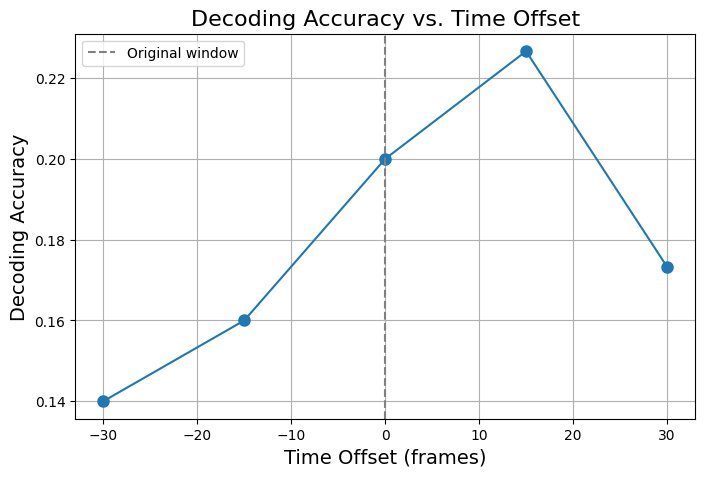

In [37]:
# ================================
# Exercise 6: Varying the Time Window Offset for Decoding
# ================================

# --- Step 1: Retrieve a Drifting Gratings Session ---
# Get sessions that contain the drifting gratings stimulus.
exps = boc.get_ophys_experiments(stimuli=['drifting_gratings'])
print("Using session_id:", exps[0]['id'])
data_set = boc.get_ophys_experiment_data(exps[0]['id'])
stim_table = data_set.get_stimulus_table('drifting_gratings')
timestamps, dff = data_set.get_dff_traces()  # dff has shape: [num_neurons, num_frames]

num_trials = stim_table.shape[0]
num_neurons = dff.shape[0]
print("Number of trials:", num_trials, "Number of neurons:", num_neurons)

# --- Step 2: Define a Range of Offsets ---
# We'll test several offsets in frames relative to the original stimulus window.
# For example, offsets of -30, -15, 0, 15, and 30 frames.
offsets = [-30, -15, 0, 15, 30]

accuracies = []  # To store decoding accuracy for each offset

# --- Step 3: Loop Over Offsets to Build a Design Matrix, Decode, and Record Accuracy ---
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

for offset in offsets:
    # Initialize design matrix and label vector for this offset.
    activity = np.zeros((num_trials, num_neurons))
    stim_labels = []

    for i, row in stim_table.iterrows():
        # Compute the window start and end with the offset applied.
        start_frame = int(row.start) + offset
        end_frame = int(row.end) + offset

        # (For simplicity, we assume these indices remain valid. In a full analysis you might check bounds.)
        activity[i, :] = dff[:, start_frame:end_frame].mean(axis=1)

        # Use the grating orientation as the label if valid; otherwise, mark as 'blank'.
        if np.isfinite(row.orientation):
            stim_labels.append(str(row.orientation))
        else:
            stim_labels.append('blank')

    stim_labels = np.array(stim_labels)

    # Exclude blank trials.
    valid_idx = stim_labels != 'blank'
    activity_valid = activity[valid_idx, :]
    stim_labels_valid = stim_labels[valid_idx]

    # Make sure there are at least two different stimulus conditions.
    if len(np.unique(stim_labels_valid)) < 2:
        accuracies.append(np.nan)
        continue

    # Split into training (75%) and testing (25%).
    num_valid = activity_valid.shape[0]
    test_index = int(0.75 * num_valid)

    activity_train = activity_valid[:test_index, :]
    activity_test  = activity_valid[test_index:, :]
    stim_train = stim_labels_valid[:test_index]
    stim_test  = stim_labels_valid[test_index:]

    # Decode using LDA.
    clf = LDA()
    clf.fit(activity_train, stim_train)
    pred = clf.predict(activity_test)
    acc = np.mean(pred == stim_test)
    accuracies.append(acc)
    print(f"Offset {offset} frames: decoding accuracy = {acc:.2f}")

# --- Step 4: Plot the Decoding Accuracy vs. Time Offset ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(offsets, accuracies, 'o-', markersize=8)
plt.xlabel("Time Offset (frames)", fontsize=14)
plt.ylabel("Decoding Accuracy", fontsize=14)
plt.title("Decoding Accuracy vs. Time Offset", fontsize=16)
plt.axvline(0, color='gray', linestyle='--', label='Original window')
plt.legend()
plt.grid(True)
plt.show()
